In [12]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

## We base our first iteration on Unicycle Kinematics.
## https://www.mathworks.com/help/robotics/ug/mobile-robot-kinematics-equations.html
## x = [x,y,heading,linear velocity]^T
## u = [heading_rate (rad/s), linear acceleration]^T


## Some constants
r = 0.1 # wheel radius

## Define our model
# x_dot = A*x + B*u

def A(r,x):
    A = np.array([[0,0,0,r*np.cos(x[2])],
              [0,0,0,r*np.sin(x[2])],
              [0,0,0,0],
              [0,0,0,0]])
    return A

def B(r,x):
    B = np.array([[0,0],
                  [0,0],
                  [1,0],
                  [0,1]])
    return B

In [81]:
## Tuning parameters
v_k = 0.01*np.array([1.0,1.0,1.0,1.0]) # process noise

w_k = 0.0*np.array([1.0,1.0,1.0,1.0]) # sensor noise

Q_k = 1*np.array([[0.5,   0,   0, 0], # model noise covariance matrix
                [  0, 0.5,   0, 0],
                [  0,   0, 0.5, 0],
                [  0,   0, 0, 0.5]])

H_k = np.array([[1.0,  0,   0, 0], # observation matrix (also known as G_k, M_k)
               [  0, 1.0,   0, 0],
               [  0,  0, 1.0, 0],
               [  0,   0, 0, 1.0]])

R_k = 0.1*np.array([[1.0,   0,    0, 0], # observation/estimate noise covariance matrix
                [  0, 1.0,    0, 0],
                [  0,    0, 1.0, 0],
                [  0,   0, 0, 1.0]])

In [82]:
## IEKF function
def IEKF(z_k, x_k_min_1, u_k_min_1, P_k_min_1,iterative,measurement,T):
    
    # z_k: observation vector
    # x_k_min_1: previous state estimate
    # u_k_min_1: previous input
    # P_k_min_1: previous covariance matrix
    
    # Prediction phase
    
    # Discretize system
    A_disc = (np.identity(4) + A(r,x_k_min_1)*T)
    B_disc = T*B(r,x_k_min_1)
    x_k = A_disc @ x_k_min_1 + B_disc @ (u_k_min_1) + w_k # predicted state estimate (x_frown)
    P_k = A_disc @ P_k_min_1 @ A_disc.T + Q_k # updated covariance matrix (pre-correction)
    
    if(measurement):
        H_k[0][0] = 1
        H_k[1][1] = 1
        H_k[2][2] = 0
        H_k[3][3] = 0
        
    # Skip correction phase if no measurements.
    if(not measurement):
        H_k[0][0] = 0
        H_k[1][1] = 0
        H_k[2][2] = 0
        H_k[3][3] = 0
    
    # Correction phase (EKF)
    S_k = H_k @ P_k @ H_k.T + R_k
    
    y_k_hat = z_k - (H_k @ x_k + v_k) # measurement estimate
    
    K_k = P_k @ H_k.T @ inv(S_k) # near-optimal Kalman gain
    
    x_k_hat = x_k + K_k @ y_k_hat # updated state estimate prediction
    
    P_k = (np.identity(4) - K_k @ H_k) @ P_k # updated covariance matrix (post-correction)
    
    
    # Iterative phase (IEKF)
    if(iterative):
        x_op_k = x_k

        for i in range(10):
            K_k = P_k @ H_k.T @ inv(S_k) # near-optimal Kalman gain
    
            x_k_hat = x_k + K_k @ (z_k - (H_k @ x_op_k + v_k) - H_k @ (x_k - x_op_k)) # updated state estimate prediction

            P_k = (np.identity(4) - K_k @ H_k) @ P_k # updated covariance matrix (post-correction)
    
            x_op_k = x_k_hat
    
    # Returning state estimate and covariance
    return x_k_hat, P_k

In [108]:
def simulate_robot():   
    x_k_min_1 = np.array([0.0,0.0,0.0,0.0]) # initial state
    P_k_min_1 = 0*np.array([[0.1, 0, 0, 0], # initial covariance (set to zero as we know the initial value)
                          [0, 0.1, 0, 0],
                          [0, 0, 0.1, 0],
                          [0, 0, 0.0, 0.1]])
    
    x_hat = []
    y_hat = []
    yaw_hat = []
    
    should_iterate = True
    
    #Initial values for simulation
    h = 0.01
    x_sim = np.array([0,0,0,0]).T #initial simulated states
    x_sim_prev = x_sim
    
    #Initial input values
    acc = 1
    headingrate = 0.1
    
    #Bookkeeping lists for plotting
    x_sim_run = []
    x_sim_x = []
    x_sim_y = []
    x_sim_yaw = []
    
    # Time array with step
    t = np.arange(0,25,h) # interval between 0 and 25 with stepsize of 0.01 => 2500 steps.
    
    for k in range(t.size):
        
        # Measurement logic
        measurement = True
        
        # Artificial sensor noise
        noise_x = 0*np.random.normal(0,v_k[0],1)[0]
        noise_y = 0*np.random.normal(0,v_k[1],1)[0]
        
        noise_a = 10*np.random.normal(0,0.1,1)[0]
        noise_omega = 1*np.random.normal(0,0.1,1)[0]
        
        # Generate states from our original model (x,y,heading)
        u_sim = np.array([acc, headingrate]).T
        x_sim_dot = A(r,x_sim)@x_sim + B(r,x_sim)@u_sim
        x_sim = x_sim + x_sim_dot*h
        x_sim_x.append(x_sim[0])
        x_sim_y.append(x_sim[1])
        x_sim_yaw.append(x_sim[2])
        
        # Generate noisy input
        u_k_min_1 = [0,0]
        u_k_min_1[0] = u_sim[0]+noise_omega
        u_k_min_1[1] = u_sim[1]+noise_a
        
         
        # Only use direct position measurements at a frequency of 1/100, otherwise use acceleration input plus prediction.
        if(k%100 == 0):
            z_k_obs = [x_sim[0]+noise_x,x_sim[1]+noise_y,0,0]
            
        else:
            measurement = False
            z_k_obs = [0,0,0,0]
        
        # Update estimate and covariance
        x_k_hat, P_k = IEKF(z_k_obs, x_k_min_1,u_k_min_1,P_k_min_1,should_iterate,measurement,h)
         
        # Get ready for the next timestep by updating the variable values
        x_k_min_1 = x_k_hat
        P_k_min_1 = P_k
        
        # Add values to lists for plotting
        x_hat.append(x_k_hat[0])
        y_hat.append(x_k_hat[1])
        yaw_hat.append(x_k_hat[2])
    
    # Plot trajectory and yaw estimates vs simulated
    plt.plot(x_hat,y_hat, label="trajectory_hat")
    plt.plot(x_sim_x, x_sim_y, label="x and y sim")
    plt.legend()
    plt.show()
    
    #plt.plot(t, yaw_hat, label="yaw_hat")
    #plt.plot(t, x_sim_yaw, label="yaw_sim")
    #plt.legend()
    #plt.show()
    

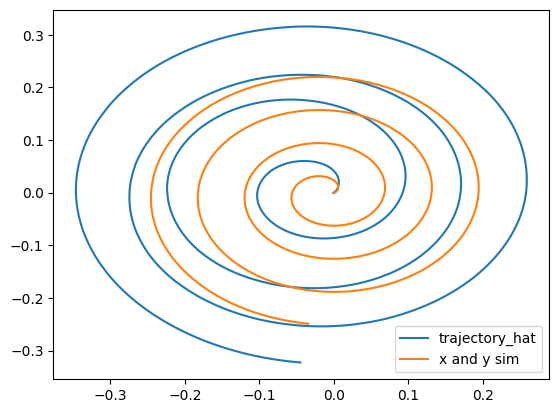

In [109]:
simulate_robot()

# Comparing EKF and IEKF
All plots are with IEKF running 10 iterations. IEKF plots are on the left, EKF on the right.
# trajectory_position_noise

When adding noise to the position measurements the EKF quickly starts seeing worsening results, but the IEKF manages to estimate the position almost perfectly!
<div style="width:1000 width px; 
            font-size:80%;  
            float: center; padding-left-right-top-bottom:0.5em;  
            border-style: solid; border-color: rgba(211, 211, 211, 0.1);">
    
<div>
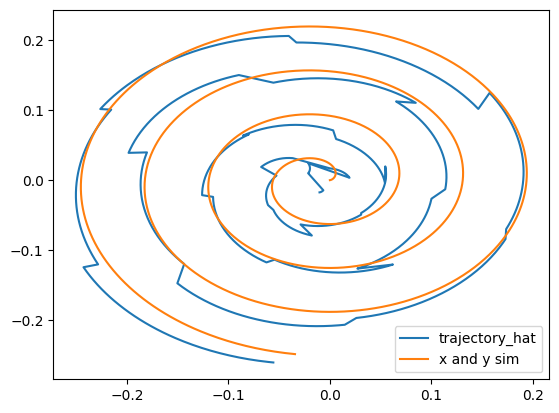
</div>

<div>
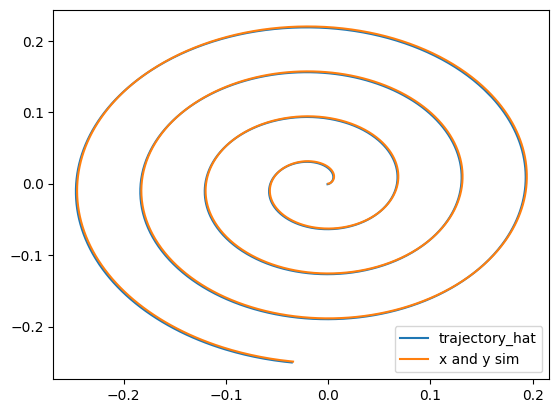
</div>
</div>


# trajectory_large_yaw_noise_no_tuning

When adding significant noise to the the heading rate measurements we can see the IEKF struggling as well, however, there have not been any attempts at tuning the filter.

<div style="width:1000 width px; 
            font-size:80%; 
            text-align:center; 
            float: center; padding-left-right-top-bottom:0.5em;  
            border-style: solid; border-color: rgba(211, 211, 211, 0.1);">
<div>
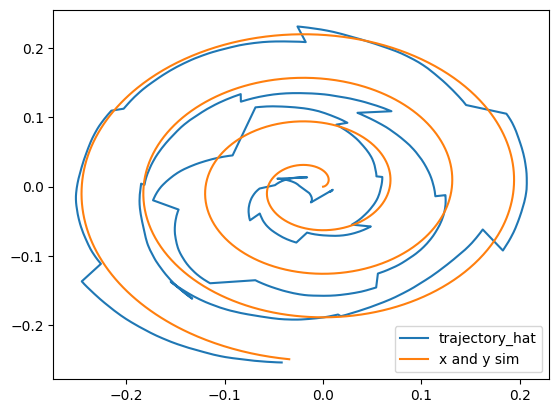
</div>

<div>
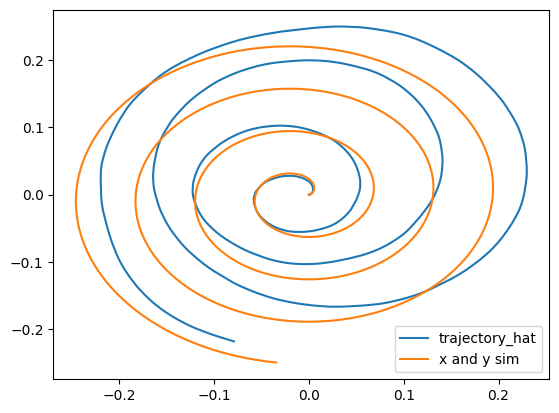
</div>
</div>

# trajectory_large_yaw_noise_with_tuning

This is with the same noise as the previous plots, but we have done som minimal tuning to the filter (heavily decreasing the trust in heading rate measurements), immediately noticing an improvement.

<div style="width:1000 width px; 
            font-size:80%; 
            text-align:center; 
            float: center; padding-left-right-top-bottom:0.5em;  
            border-style: solid; border-color: rgba(211, 211, 211, 0.1);">
<div>
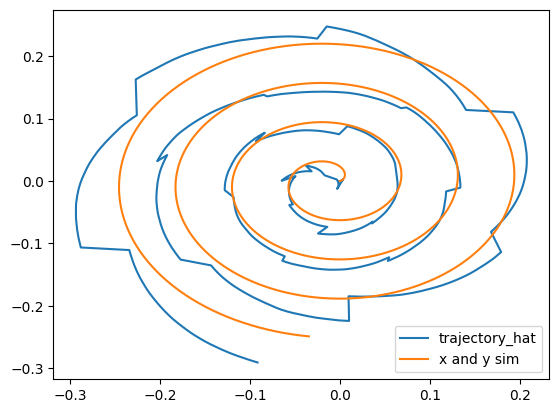
</div>

<div>
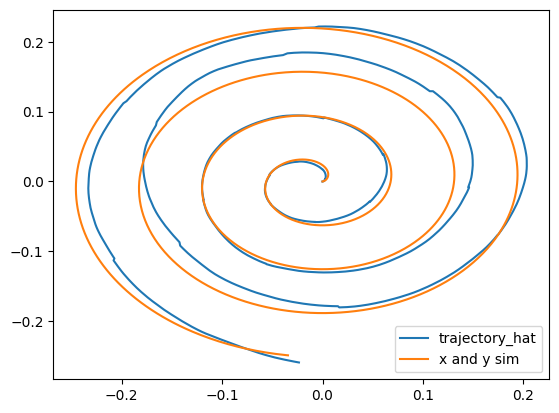
</div>
</div>

# trajectory_input_noise 

With less noise in position measurements, but now increasing the acceleration and heading rate noise, the IEKF still works really well while the EKF struggles.

<div style="width:1000 width px; 
            font-size:80%; 
            text-align:center; 
            float: center; padding-left-right-top-bottom:0.5em;  
            border-style: solid; border-color: rgba(211, 211, 211, 0.1);">
<div>
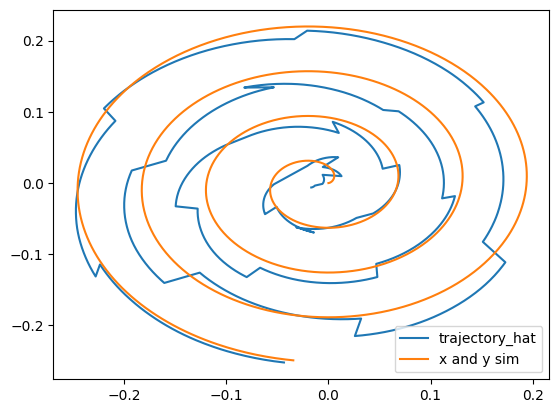
</div>

<div>
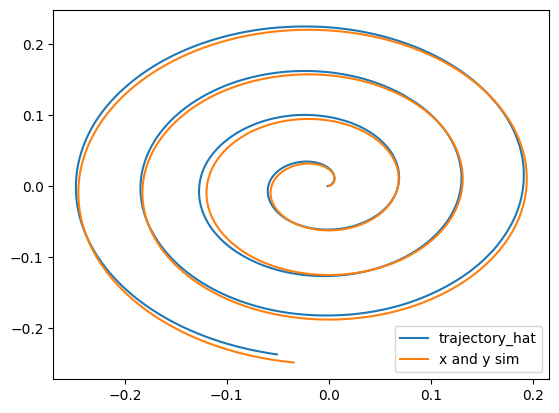
</div>
</div>

# trajectory_large_acc_noise_iekf 

Removing all noise in position measurments while increasing the acceleration noise by 10 we can see that also the IEKF is performing poorly (keeping in mind this is without tuning the filter). This feels intuitive as the position measurments only are available each second, having to use really noisy measurments for most of the time.
What's surprising is how well the EKF is performing compared to IEKF, which is not what we would've expected after the previous results.

<div style="width:1000 width px; 
            font-size:80%; 
            text-align:center; 
            float: center; padding-left-right-top-bottom:0.5em;  
            border-style: solid; border-color: rgba(211, 211, 211, 0.1);">
<div>
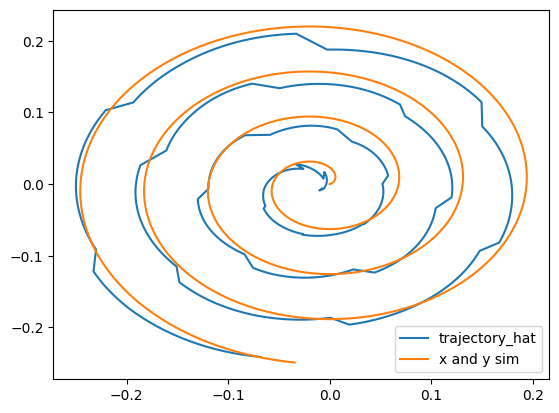
</div>

<div>
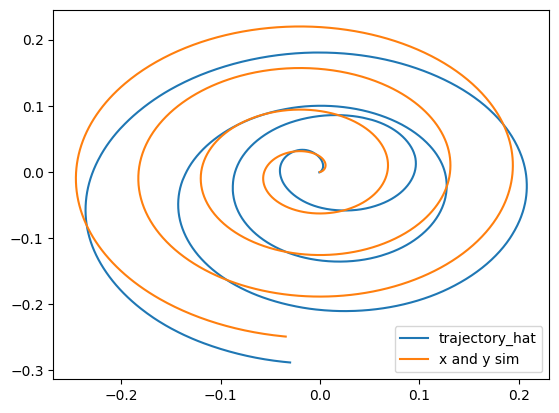
</div>
</div>